### Fair Random Forest

This notebook investigates the possibility of weighing the decisions of the trees of a random forest ensemble to mitigate the bias of the ensemble model. We work with the banking dataset of UCI Machine Learning database.

Workflow: 

- Data ingestion <br>
- Create "gender_male" synthetic feature <br>
- Calculate disparate impact for "gender_male" <br>
- Model training: Random forest <br>
- Calculate difference of equality (diff eoo) of opportunity of model for "gender_male" <br>
- Calculate diff eoo and accuracies for predictions of each tree in ensemble <br>
- Weight trees accordingly with their diff eoo's. <br>
- Predict with new weights and calculate diff eoo of model<br>
- Comment on results<br>
- Repeat procedure for "job_student" variable<br>
- Comment on results<br>
- Test different alpha values for weight distribution

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("bank-full.csv",sep=";") #Read data as pandas dataframe
df["month"]=pd.to_datetime(df.month,format="%b").dt.month #Parse month text and retrieve numbers instead
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no


In [3]:
df_nums=pd.get_dummies(df,drop_first=True)
df_nums.head()

,age,balance,day,month,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,...,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,5,261,1,-1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,44,29,5,5,151,1,-1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,33,2,5,5,76,1,-1,0,0,1,...,0,0,1,1,0,1,0,0,1,0
3,47,1506,5,5,92,1,-1,0,1,0,...,1,0,1,0,0,1,0,0,1,0
4,33,1,5,5,198,1,-1,0,0,0,...,1,0,0,0,0,1,0,0,1,0


We will create the discriminative variable "gender_male". 1 will indicate male, and 0 female. The advantaged gender will be male. We desire the data to exhibit certain disparate impact which will reflect to the trained model as well. We need males to be more eligible for the desired state: "y_yes" being 1. This is why we will create the values by the help of randomization: 70% of the time the values will be the same with "y_yes", the rest will be picked randomly.

In [4]:
def gen_gender(value): #Function to create unfair gender variable
    if value==1: #If desired state       
        if np.random.random()>0.4: #Most of the time gender will be male
            return 1
        else:
            return np.random.randint(0,2)
    else: #If not desired statate, completely random
        return np.random.randint(0,2)

df_nums["gender_male"]=df_nums.y_yes.apply(gen_gender) #Create the variable

#Calculate disparate impact: Difference between ratios of access of genders to advantaged class
fem_adv=df_nums[(df_nums.gender_male==0) & (df_nums.y_yes==1)].shape[0]/df_nums[df_nums.gender_male==0].shape[0]
men_adv=df_nums[(df_nums.gender_male==1) & (df_nums.y_yes==1)].shape[0]/df_nums[df_nums.gender_male==1].shape[0]
print(f"Female ratio with access to favorable class: {fem_adv:.2f}%")
print(f"Male ratio with access to favorable class: {men_adv:.2f}%")

Female ratio with access to favorable class: 0.05%
Male ratio with access to favorable class: 0.17%


We have successfully created the gender variable so that the data is skewed towards males in terms of owning the favorable "y_yes" class.

In [5]:
#Split train and test
x_train, x_test, y_train, y_test = train_test_split(df_nums.drop(columns=["y_yes"]), df_nums["y_yes"], test_size=0.33, random_state=42)
print(x_train.shape[0], x_test.shape[0]) #Take a look at the number of specimen in the split

30291 14920


In [11]:
%%time
model= RandomForestClassifier(n_estimators=1000, max_depth=4,class_weight ="balanced")
model.fit(x_train, y_train)

#Predict Output
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Accuracy
print(accuracy_score(y_train,y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.8269122841768182
0.8217828418230563
Wall time: 1min 25s


Random forest debiasing for "gender_male"

Results are not too bad. We need to check the difference of equality of opportunity on gender variable.

In [51]:
def diff_eoo(y,pred,disc): #Function to calculate difference of equality of opportunity
    data=list(zip(y,pred,disc))
    data=pd.DataFrame(data,columns=["y","pred","disc"])
    #Opportunity achievement rate of advantaged and disadvantaged individuals
    opp_adv=data[(data.disc==1) & (data.y==1) & (data.pred==1)].shape[0]/data[(data.disc==1) & (data.y==1)].shape[0]
    opp_dis=data[(data.disc==0) & (data.y==1) & (data.pred==1)].shape[0]/data[(data.disc==0) & (data.y==1)].shape[0]
    return round(opp_adv-opp_dis,2) #Difference of equality of opportunity

In [13]:
disc=x_test.gender_male.values #Values of discriminative variable as a list
y=y_test.values #Values of prediction variable as a list
print("Difference of equality of opportunity:",diff_eoo(y,y_pred_test,disc))

Difference of equality of opportunity: 0.32


30% is a serious difference of equality of opportunity rate. Let's see this score and accuracies for each tree.

In [14]:
%%time
tree_scores=[] #Declare empty array to collect the scores of each tree
tree_preds=[] #Collect the predictions

for tree in model.estimators_:
    iter_pred=tree.predict(x_test) #Predictions for the current tree
    iter_acc=round(accuracy_score(y,iter_pred),2) #Accuracy of current tree
    iter_diff=round(diff_eoo(y,iter_pred,disc),2) #Difference of equality of opportunity of current tree
    tree_scores.append([iter_diff,iter_acc]) #Collect scores of each tree
    tree_preds.append(iter_pred)

tree_scores=pd.DataFrame(tree_scores,columns=["Diff","Acc"])
tree_scores.head()

Wall time: 2min 6s


,Diff,Acc
0,0.49,0.80
1,0.09,0.75
2,0.02,0.64
3,0.64,0.66
4,0.01,0.64


<AxesSubplot:ylabel='Frequency'>

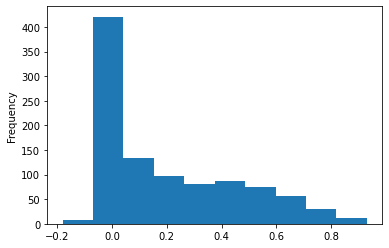

In [15]:
#Let's plot the histogram of the diff_eoo's for all the trees
tree_scores["Diff"].plot.hist()

The highest vote based random forest yielded roughly 30% difference of equality of opportunity. Each tree had equal rights to vote. We can make the model fairer by assigning more weight to fairer trees. 

In [16]:
#We take absolute of the diff of eoo's. The reverse of the discrimination is also not desired.
tree_scores["Diff_abs"]=np.abs(tree_scores["Diff"])

In [17]:
def weights(diff_eoo,alpha=1): #Assign weights: As alpha increases the weights of fair trees increase
    w_raw=np.exp(diff_eoo)**(-1*alpha) #(1/(e^diff_eoo))^alpha
    return w_raw/np.sum(w_raw)

In [18]:
tree_scores["weight"]=weights(tree_scores["Diff_abs"],alpha=10)
tree_scores[:10]

,Diff,Acc,Diff_abs,weight
0,0.49,0.80,0.49,1.697081e-05
1,0.09,0.75,0.09,9.265746e-04
2,0.02,0.64,0.02,1.865892e-03
3,0.64,0.66,0.64,3.786698e-06
4,0.01,0.64,0.01,2.062130e-03
5,0.62,0.78,0.62,4.625084e-06
6,-0.01,0.72,0.01,2.062130e-03
7,0.80,0.53,0.80,7.645212e-07
8,-0.02,0.68,0.02,1.865892e-03
9,0.40,0.50,0.40,4.174144e-05


In [19]:
#Weighted predictions of all trees
pred_w=[np.multiply(tree_preds[i],tree_scores.loc[i,"weight"]) for i in range(0,len(model.estimators_))]
pred_w=np.array(pred_w)
pred_w.shape

(1000, 14920)

In [20]:
#We sum the weighted predictions of each tree, for each data point, then label them by the cut-off 0.5
fair_pred=np.round(pred_w.sum(axis=0))
fair_pred[:10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [21]:
#Let's calculate the difference of equality of opportunity
print("Difference of equality of opportunity:",diff_eoo(y,fair_pred,disc))
print("Accuracy:",round(accuracy_score(y,fair_pred),2))

Difference of equality of opportunity: 0.02
Accuracy: 0.81


We have made the model much fairer without losing much accuracy compared to the model default. The selection of weights is very important to adjust accuracy-fairness trade-off. It depends on the alpha parameter. The higher the alpha, the higher the gap between the weights of fair trees and unfair trees. We need to compare the confusion matrices of the original predictions and fair predictions to see the complete picture of the impact of our weighted fair decision.

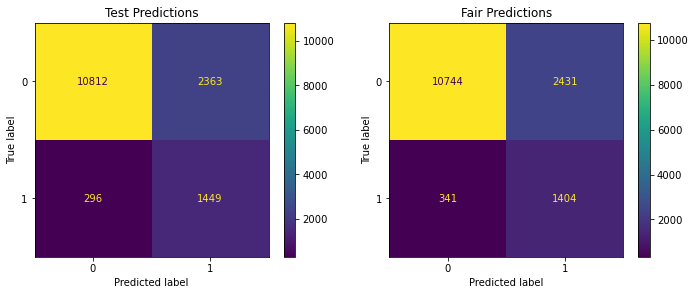

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y,y_pred_test),display_labels=[0,1]).plot(ax=axes[0])
axes[0].set_title("Test Predictions")
ConfusionMatrixDisplay(confusion_matrix(y,fair_pred),display_labels=[0,1]).plot(ax=axes[1])
axes[1].set_title("Fair Predictions")
fig.tight_layout()

<h3>Random forest debiasing for "job_retired"</h3>

In our case, since we have produced the discriminative variable ourselves, the other variables were likely not to explain this made variable. But in many scenarios, data has historical bias present in variables. An effective way to test the assumption that our success was merely due to the non-existing historical bias, we could pick an existing binary variable in the data with strong correlations with other variables. This binary variable will be treated as discriminative variable. It will be challenged with the same procedure as above. We also need to make sure that it represents certain disparate impact just as our made gender variable.

In [38]:
disc_var="job_retired"
#Calculate disparate impact: Difference between ratios of access of genders to favorable class
group_dis=df_nums[(df_nums[disc_var]==0) & (df_nums.y_yes==1)].shape[0]/df_nums[df_nums[disc_var]==0].shape[0]
group_adv=df_nums[(df_nums[disc_var]==1) & (df_nums.y_yes==1)].shape[0]/df_nums[df_nums[disc_var]==1].shape[0]
print(f"Disadvantaged class ratio with access to favorable class: {group_dis:.2f}%")
print(f"Advantaged ratio with access to favorable class: {group_adv:.2f}%")

Disadvantaged class ratio with access to favorable class: 0.11%
Advantaged ratio with access to favorable class: 0.23%


"job_retired" is a good binary variable which we will claim to be sensitive variable (such as race and class) so we will be able to see the debiasing random forest in action with an organic variable embedded in the model. Let's see the correlations of "job_student" with other variables.

In [39]:
df_nums.corr()["job_retired"]

age                    0.447378
balance                0.046900
day                   -0.010123
month                  0.024953
duration               0.026032
campaign              -0.030913
pdays                 -0.006315
previous               0.005818
job_blue-collar       -0.120251
job_entrepreneur      -0.042342
job_housemaid         -0.038557
job_management        -0.118091
job_retired            1.000000
job_self-employed     -0.043678
job_services          -0.073032
job_student           -0.033420
job_technician        -0.103185
job_unemployed        -0.039552
job_unknown           -0.018384
marital_married        0.076288
marital_single        -0.119892
education_secondary   -0.036089
education_tertiary    -0.066780
education_unknown      0.013290
default_yes           -0.011290
housing_yes           -0.156633
loan_yes              -0.014861
contact_telephone      0.107299
contact_unknown       -0.036504
poutcome_other        -0.004691
poutcome_success       0.055485
poutcome

It is linearly correlated with a few variables to a certain degree. We do not require training new model. We will utilize the existing random forest model and its trees.

In [40]:
disc=x_test.job_retired.values #Values of discriminative variable as a list
#We have y, and y_pred already defined to calculate difference of eoo.  
print("Difference of equality of opportunity:",diff_eoo(y,y_pred_test,disc))

Difference of equality of opportunity: 0.11


Since the difference of eoo is modest, the target will be zeroing the bias out with the same procedure applied to "gender_male" previously.

In [41]:
%%time
tree_scores=[] #Declare empty array to collect the scores of each tree
tree_preds=[] #Collect the predictions

for tree in model.estimators_:
    iter_pred=tree.predict(x_test) #Predictions for the current tree
    iter_acc=round(accuracy_score(y,iter_pred),2) #Accuracy of current tree
    iter_diff=round(diff_eoo(y,iter_pred,disc),2) #Difference of equality of opportunity of current tree
    tree_scores.append([iter_diff,iter_acc]) #Collect scores of each tree
    tree_preds.append(iter_pred)

tree_scores=pd.DataFrame(tree_scores,columns=["Diff","Acc"])
tree_scores.head()

Wall time: 2min 16s


,Diff,Acc
0,-0.01,0.80
1,0.02,0.75
2,0.12,0.64
3,0.16,0.66
4,0.26,0.64


In [45]:
#We take absolute of the diff of eoo's. The reverse of the discrimination is also not desired.
tree_scores["Diff_abs"]=np.abs(tree_scores["Diff"])
#Calculate weights so that the fair trees will have more in the say of predicted class of a data point
tree_scores["weight"]=weights(tree_scores["Diff_abs"],alpha=10)
tree_scores[:10]

,Diff,Acc,Diff_abs,weight
0,-0.01,0.80,0.01,0.001942
1,0.02,0.75,0.02,0.001757
2,0.12,0.64,0.12,0.000646
3,0.16,0.66,0.16,0.000433
4,0.26,0.64,0.26,0.000159
5,0.21,0.78,0.21,0.000263
6,-0.02,0.72,0.02,0.001757
7,0.04,0.53,0.04,0.001439
8,0.06,0.68,0.06,0.001178
9,0.11,0.50,0.11,0.000714


In [46]:
#Weighted predictions of all trees
pred_w=[np.multiply(tree_preds[i],tree_scores.loc[i,"weight"]) for i in range(0,len(model.estimators_))]
pred_w=np.array(pred_w)
#We sum the weighted predictions of each tree, for each data point, then label them by the cut-off 0.5
fair_pred=np.round(pred_w.sum(axis=0))
#Let's calculate the difference of equality of opportunity
print("Difference of equality of opportunity:",diff_eoo(y,fair_pred,disc))
print("Accuracy:",round(accuracy_score(y,fair_pred),2))

Difference of equality of opportunity: 0.01
Accuracy: 0.79


The weighted prediction of trees were able to decrease the difference of equality of opportunity for feature "job_retired" from 0.11 down to 0.01 successfully. Both our synthetically made and organic model features with correlations with other features proved effective with this debiasing method. The lose of accuracy in the process is not negligible but tolerable.

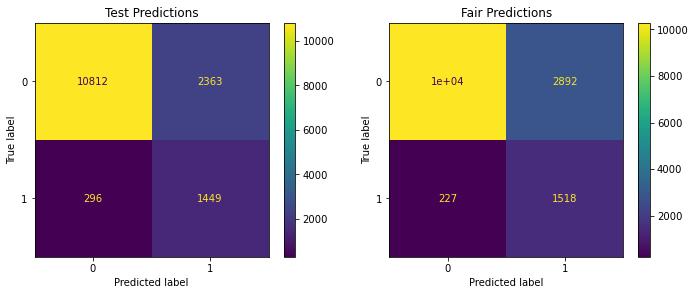

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ConfusionMatrixDisplay(confusion_matrix(y,y_pred_test),display_labels=[0,1]).plot(ax=axes[0])
axes[0].set_title("Test Predictions")
ConfusionMatrixDisplay(confusion_matrix(y,fair_pred),display_labels=[0,1]).plot(ax=axes[1])
axes[1].set_title("Fair Predictions")
fig.tight_layout()

<h3>Difference of EOO for Different Values of Alpha</h3>

In [91]:
%%time
accuracy=[] #Initiate an array to collect accuracy values 
diff_eoos=[] #Initita an array to collect diff_eoo
alphas=[] #Collect alphas

for alpha in np.arange(0,100,0.5): #Start from zero and increase alpha
    iter_w=weights(tree_scores["Diff_abs"],alpha=alpha)
    #Weighted predictions of all trees
    pred_w=[np.multiply(tree_preds[i],iter_w[i]) for i in range(0,len(model.estimators_))]
    pred_w=np.array(pred_w)
    fair_pred=np.round(pred_w.sum(axis=0)) #Fair predictions
    accuracy.append(accuracy_score(y,fair_pred))
    diff_eoos.append(diff_eoo(y,fair_pred,disc))
    alphas.append(alpha)

Wall time: 5min 13s


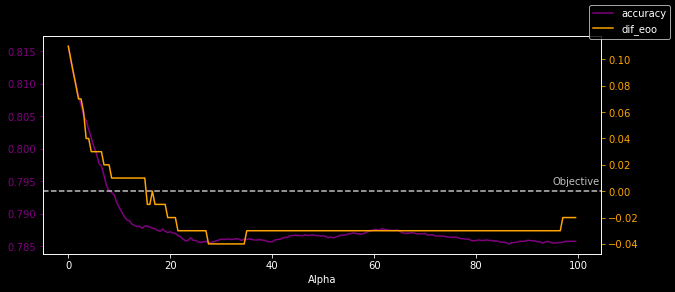

In [109]:
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()
#Our objective: 0 discrimination
ax2.text(95,0.005,"Objective",color="silver")
ax2.axhline(0, color='silver',linestyle ="--")
ax1.set_xlabel("Alpha")
ax1.plot(alphas,accuracy,label="accuracy",color="purple")
ax2.plot(alphas,diff_eoos,label="dif_eoo",color="orange")
ax2.tick_params(axis="y",colors="orange")
ax1.tick_params(axis="y",colors="purple")
fig.legend()
plt.show()

As the alpha increases, it increases the impact of the fairer trees in label of observations, this is why the difference of equality of opportunity decreases. The accuracy also decreases with it, since we prefer fairer decisions over accurate decisions. The trees with the information of discriminative class in the desired outputs coming are preferred less and less even though they explain a portion of the prediction variable. 

The reason the difference of equality of opportunity score goes below zero is that we have trees in the ensemble that applies the discrimination in the reversed direction. The advantaged label turns disadvantanged. As the weight gap between fair/non-fair trees increase, the predominancy of the usual discrimination is lifted and the trees with lower discrimination scores compete within each other. It seems that as the alpha value increases, the trees with opposite type of discrimination becomes dominant. If there are enough trees in the ensemble to create variety of scores, we should finally expect the convergence to 0 difference of equality of opportunity. For this objective, we need to pick an alpha more than 100. But we will leave this to further studies.

The best alpha here is the one which sustains our objective best: minimal or no difference of equality of opportunity and as much accuracy as possible. Ideally, it is between 15 and 20.